# Preprocessed Citibike Data: Exploratory Data Analysis

## Import libraries

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
from pandas.api.types import CategoricalDtype
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go

## Import and load data

Import preprocessed data:

In [2]:
cb_raw = pd.read_csv('../../data/02_processed/concat_file_processed.csv', 
                     parse_dates=['starttime', 'stoptime'])

Drop unused index:

In [3]:
cb_raw = cb_raw.drop('Unnamed: 0', axis=1)

Make a copy: 

In [4]:
cb = cb_raw.copy()

## Inspect data frame

Get dimensions of data frame and datatypes of each feature:

In [5]:
cb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4605356 entries, 0 to 4605355
Data columns (total 15 columns):
bikeid                   int64
birthyear                float64
endstationid             float64
endstationlatitude       float64
endstationlongitude      float64
endstationname           object
gender                   int64
startstationid           float64
startstationlatitude     float64
startstationlongitude    float64
startstationname         object
starttime                datetime64[ns]
stoptime                 datetime64[ns]
tripduration             float64
usertype                 object
dtypes: datetime64[ns](2), float64(8), int64(2), object(3)
memory usage: 527.0+ MB


Randomly sample five observations:

In [6]:
cb.sample(n=5)

,bikeid,birthyear,endstationid,endstationlatitude,endstationlongitude,endstationname,gender,startstationid,startstationlatitude,startstationlongitude,startstationname,starttime,stoptime,tripduration,usertype
1395556,33252,1969.0,335.0,40.729039,-73.994046,Washington Pl & Broadway,2,401.0,40.720196,-73.989978,Allen St & Rivington St,2019-10-21 15:22:45.288,2019-10-21 15:33:30.546,645.0,Subscriber
1611127,29944,1987.0,3143.0,40.776321,-73.964274,5 Ave & E 78 St,2,3374.0,40.799484,-73.955613,Central Park North & Adam Clayton Powell Blvd,2018-07-30 17:59:08.350,2018-07-30 18:11:26.782,738.0,Subscriber
2042988,20021,1977.0,263.0,40.717290,-73.996375,Elizabeth St & Hester St,2,301.0,40.722174,-73.983688,E 2 St & Avenue B,2016-04-12 10:37:28.000,2016-04-12 10:49:54.000,746.0,Subscriber
3902652,18955,1969.0,321.0,40.699918,-73.989718,Cadman Plaza E & Red Cross Pl,0,319.0,40.711066,-74.009447,Fulton St & Broadway,2019-07-25 12:25:21.996,2019-07-25 13:17:05.715,3103.0,Customer
3382445,14681,1994.0,314.0,40.693830,-73.990539,Cadman Plaza West & Montague St,1,521.0,40.750967,-73.994442,8 Ave & W 31 St N,2013-06-24 10:47:49.000,2013-06-24 10:57:09.000,560.0,Subscriber


Check for missing values – there should be none:

In [7]:
cb.isnull().sum()

bikeid                   0
birthyear                0
endstationid             0
endstationlatitude       0
endstationlongitude      0
endstationname           0
gender                   0
startstationid           0
startstationlatitude     0
startstationlongitude    0
startstationname         0
starttime                0
stoptime                 0
tripduration             0
usertype                 0
dtype: int64

## Data preprocessing

Show unique values per feature:

In [8]:
pd.DataFrame.from_records([(col, cb[col].nunique()) for col in cb.columns],
                          columns=['Feature', 'Number of Unique Values']).sort_values(by=['Number of Unique Values'])

,Feature,Number of Unique Values
6,gender,3
14,usertype,3
1,birthyear,85
7,startstationid,1058
2,endstationid,1073
10,startstationname,1089
5,endstationname,1107
9,startstationlongitude,1121
4,endstationlongitude,1140
8,startstationlatitude,1201


### Define features

Define numerical features:

In [9]:
map_feat = ['endstationlatitude','endstationlongitude','startstationlatitude','startstationlongitude']
datetime_feat = ['birthyear','starttime', 'stoptime']
cont_feat = map_feat + datetime_feat + ['tripduration']

Define categorical features:

In [10]:
num_nom_feat = ['bikeid','endstationid','startstationid','gender']
cat_nom_feat = ['endstationname','startstationname','usertype']
nom_feat = num_nom_feat + cat_nom_feat

### Perform datatype conversions

Convert features to `float16` or `int16` to reduce memory:

In [11]:
cb.birthyear = cb.birthyear.astype('float16').astype('int16')

In [12]:
cb[map_feat] = cb[map_feat].apply(lambda x: x.astype('float16'))

In [13]:
float_to_int = ['startstationid','endstationid','tripduration','bikeid']

cb[float_to_int] = cb[float_to_int].apply(lambda x: x.astype('int16'))

Convert untreated nominal features to categorical datatype to reduce memory:

In [14]:
cb[cat_nom_feat] = cb[cat_nom_feat].apply(lambda x: x.astype('category'))

Convert to datetime format:

In [15]:
cb['birthyear'] = pd.to_datetime(cb.birthyear, format='%Y')
# cb['birthyear'] = cb['birthyear'].dt.year

Check for successful datatype conversion and reduction in memory:

In [16]:
cb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4605356 entries, 0 to 4605355
Data columns (total 15 columns):
bikeid                   int16
birthyear                datetime64[ns]
endstationid             int16
endstationlatitude       float16
endstationlongitude      float16
endstationname           category
gender                   int64
startstationid           int16
startstationlatitude     float16
startstationlongitude    float16
startstationname         category
starttime                datetime64[ns]
stoptime                 datetime64[ns]
tripduration             int16
usertype                 category
dtypes: category(3), datetime64[ns](3), float16(4), int16(4), int64(1)
memory usage: 232.9 MB


## Feature engineering

### Impute missing or incorrect values

Check observations where latitude and longitude don't make any sense:

In [17]:
observe = [4455178, 2022803, 2051817, 3007606, 2022782, 2035624, 3539070, 956266]

In [18]:
cb.iloc[observe,:]

,bikeid,birthyear,endstationid,endstationlatitude,endstationlongitude,endstationname,gender,startstationid,startstationlatitude,startstationlongitude,startstationname,starttime,stoptime,tripduration,usertype
4455178,31949,1994-01-01,3186,40.71875,-74.0625,Grove St PATH,2,3480,0.00000,0.0,WS Don't Use,2017-10-02 14:36:25,2017-10-02 14:51:36,910,Subscriber
2022803,17615,1986-01-01,3230,40.75000,-74.0000,Penn Station Valet,1,3240,0.00000,0.0,NYCBS Depot BAL - DYR,2016-12-23 15:04:58,2016-12-23 15:13:22,503,Subscriber
2051817,17215,1900-01-01,3240,0.00000,0.0000,NYCBS Depot BAL - DYR,0,327,40.71875,-74.0,Vesey Pl & River Terrace,2016-04-17 10:05:25,2016-04-18 00:07:42,-14999,Customer
3007606,20140,1967-01-01,3240,0.00000,0.0000,NYCBS Depot BAL - DYR,1,303,40.71875,-74.0,Mercer St & Spring St,2016-01-21 18:31:28,2016-02-01 03:01:19,-22914,Subscriber
2022782,17615,1986-01-01,3240,0.00000,0.0000,NYCBS Depot BAL - DYR,1,449,40.75000,-74.0,W 52 St & 9 Ave,2016-12-23 14:53:57,2016-12-23 15:04:06,609,Subscriber
2035624,15812,1952-01-01,3240,0.00000,0.0000,NYCBS Depot BAL - DYR,1,267,40.75000,-74.0,Broadway & W 36 St,2016-04-06 14:40:44,2016-04-06 14:52:09,685,Subscriber
3539070,26076,1961-01-01,3240,0.00000,0.0000,NYCBS Depot BAL - DYR,1,447,40.75000,-74.0,8 Ave & W 52 St,2016-11-17 19:34:14,2016-11-17 19:42:25,491,Subscriber
956266,25297,1984-01-01,3240,0.00000,0.0000,NYCBS Depot BAL - DYR,1,476,40.75000,-74.0,E 31 St & 3 Ave,2016-10-18 16:30:06,2016-10-18 16:51:43,1296,Subscriber


Correct errors and impute most likely values:

In [19]:
cb.loc[cb['endstationlatitude'] == 0, 'endstationlatitude'] = 40.75
cb.loc[cb['endstationlongitude'] == 0, 'endstationlongitude'] = -74.0
cb.loc[cb['startstationlongitude']==0, 'startstationlongitude'] = -74.0
cb.loc[cb['startstationlatitude'] == 0, 'startstationlatitude'] = 40.75

Drop observation where `startstationname` reads "WS Don't Use":

In [20]:
cb.drop(4455178, axis=0, inplace=True)
cb.reset_index()

,index,bikeid,birthyear,endstationid,endstationlatitude,endstationlongitude,endstationname,gender,startstationid,startstationlatitude,startstationlongitude,startstationname,starttime,stoptime,tripduration,usertype
0,0,16852,1991-01-01,252,40.71875,-74.0000,MacDougal St & Washington Sq,1,312,40.71875,-74.0000,Allen St & Stanton St,2017-09-01 00:04:15.000,2017-09-01 00:11:18.000,422,Subscriber
1,1,27730,1983-01-01,468,40.75000,-74.0000,Broadway & W 56 St,1,478,40.75000,-74.0000,11 Ave & W 41 St,2017-09-01 00:06:19.000,2017-09-01 00:17:09.000,650,Subscriber
2,2,28032,1989-01-01,395,40.68750,-74.0000,Bond St & Schermerhorn St,1,237,40.71875,-74.0000,E 11 St & 2 Ave,2017-09-01 00:07:34.000,2017-09-01 00:29:49.000,1334,Subscriber
3,3,15651,1989-01-01,3449,40.71875,-73.9375,Eckford St & Engert Ave,2,3090,40.71875,-73.9375,N 8 St & Driggs Ave,2017-09-01 00:10:49.000,2017-09-01 00:13:52.000,182,Subscriber
4,4,17018,1900-01-01,402,40.75000,-74.0000,Broadway & E 22 St,0,325,40.75000,-74.0000,E 19 St & 3 Ave,2017-09-01 00:11:00.000,2017-09-01 00:15:39.000,278,Customer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4605350,4605351,27660,1990-01-01,3151,40.78125,-73.9375,E 81 St & York Ave,1,515,40.75000,-74.0000,W 43 St & 10 Ave,2020-01-31 23:51:51.926,2020-02-01 00:17:04.412,1512,Subscriber
4605351,4605352,-26642,1981-01-01,532,40.71875,-73.9375,S 5 Pl & S 5 St,1,3093,40.71875,-73.9375,N 6 St & Bedford Ave,2020-01-31 23:51:56.901,2020-01-31 23:57:05.299,308,Subscriber
4605352,4605353,-25475,1983-01-01,3374,40.81250,-73.9375,Central Park North & Adam Clayton Powell Blvd,1,3496,40.78125,-73.9375,1 Ave & E 110 St,2020-01-31 23:53:54.344,2020-01-31 23:59:52.961,358,Subscriber
4605353,4605354,-24990,1993-01-01,305,40.75000,-73.9375,E 58 St & 3 Ave,1,3671,40.78125,-73.9375,E 81 St & 2 Ave,2020-01-31 23:53:59.607,2020-02-01 00:02:46.609,527,Subscriber


Create csv file of cleaned and preprocessed dataset prior to feature engineering:

In [21]:
cb.to_csv('../../data/02_processed/citibike_preprocessed.csv', index=False)

### Create features

Define helper function to calculate distance between coordinates:

In [22]:
from pyproj import Geod

def calc_vincenty_dist(lat1, lon1, lat2, lon2): 
    az12, az21, dist = Geod(ellps='WGS84').inv(lon1, lat1, lon2, lat2)
    return dist

In [23]:
# Haversine & inclination 29 degrees to True north
# Credits: https://www.movable-type.co.uk/scripts/latlong.html,
# https://gist.github.com/jkAtGitHub/8ae7da4d5dacb9969bff43500b5efbc0#file-manhattan_dist-py
def calc_haversine_dist(lat1, lon1, lat2, lon2):
    lat1, lat2, lon1, lon2 = np.radians(lat1), np.radians(lat2), np.radians(lon1), np.radians(lon2)
    dlat, dlon = lat2 - lat1, lon2 - lon1
    r = 3963 # Earth's radius in miles
    
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a)) 
    
    total_dist = r * c
    return total_dist

def calc_manh_disth(lat1, lon1, lat2, lon2):
    start = np.stack([lat1, lon1], axis=1)
    end = np.stack([lat2, lon2], axis=1)
    
    theta1, theta2 = np.radians(-28.904), np.radians(28.904)
    rmat1 = np.array([[np.cos(theta1), np.sin(theta1)], 
                      [-np.sin(theta1), np.cos(theta1)]])
    rmat2 = np.array([[np.cos(theta2), np.sin(theta2)], 
                      [-np.sin(theta2), np.cos(theta2)]])
    
    start_rot = rmat1 @ start.T
    end_rot = rmat1 @ end.T
    
    hinge = np.stack((start_rot[0,:], end_rot[1,:]))
    hinge_coords = rmat2 @ hinge
    
    manh_dist = calc_haversine_dist(start.T[0], start.T[1], hinge_coords[0], hinge_coords[1]) + calc_haversine_dist(hinge_coords[0], hinge_coords[1], end.T[0], end.T[1])
    return manh_dist

# Unused functions -----------------------------------------------
# # Cartesian Coordinate system, output in latlong dist
# def calc_manh_distc(lat, lon):
#     return sum(abs(lat_i-lat_j) for lat_i, lat_j in zip(lat, lon))

Create new features, `vicentydistance` and `manhdistance` (both in miles):

In [24]:
cb['vicentydistance'] = calc_vincenty_dist(cb.startstationlatitude.tolist(), 
                                        cb.startstationlongitude.tolist(),
                                        cb.endstationlatitude.tolist(),
                                        cb.endstationlongitude.tolist())
cb['vicentydistance'] = cb['vicentydistance'].apply(lambda x: x*0.000621371).astype('float16') # Convert from meters to miles

In [25]:
cb['manhdistance'] = calc_manh_disth(cb.startstationlatitude,
                                     cb.startstationlongitude,
                                     cb.endstationlatitude,
                                     cb.endstationlongitude).astype('float16')

Create new features, `startmonth` and `endmonth`:

In [26]:
cb['startmonth'] = cb['starttime'].dt.month.astype('int16')
cb['stopmonth'] = cb['stoptime'].dt.month.astype('int16')

Create new features for days of week, `startdayname` and `enddayname` (along with their numerical codes):

In [27]:
cb['startdayname'] = cb['starttime'].dt.day_name().astype('category')
cb['startday'] = cb['starttime'].dt.dayofweek.astype('int16')
cb['stopdayname'] = cb['stoptime'].dt.day_name().astype('category')
cb['stopday'] = cb['stoptime'].dt.dayofweek.astype('int16')

In [28]:
# def trip_day(df):
#     start_temp = pd.DataFrame({'startday': df['startdayofweek'].tolist(), 'code': df['startdayofweek_code'].tolist()})
#     end_temp = pd.DataFrame({'endday': df['enddayofweek'].tolist(), 'code': df['enddayofweek_code'].tolist()})
#     return pd.merge(start_temp, end_temp, left_on='startday', right_on='endday')

# start_temp = pd.DataFrame({'day': cb['startdayofweek'].tolist(), 'code': cb['startdayofweek_code'].tolist()})
# end_temp = pd.DataFrame({'day': cb['enddayofweek'].tolist(), 'code': cb['enddayofweek_code'].tolist()})

# df_list = [start_temp, end_temp]
# for df in df_list:
#     df.set_index(['day'], inplace=True)

# df = pd.concat(df_list, axis=1) # join='inner'
# df.reset_index(inplace=True)

Create new features, `starthour` and `endhour`:

In [29]:
cb['starthour'] = cb['starttime'].dt.hour.astype('int16')
cb['endhour'] = cb['stoptime'].dt.hour.astype('int16')

Create new features, `startboro` and `endboro`:

In [30]:
import geopandas as gpd
import geopy
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
from tqdm._tqdm_notebook import tqdm_notebook

In [31]:
coords_df = pd.DataFrame({'startcoords': zip(cb.startstationlatitude, cb.startstationlongitude), 
              'endcoords': zip(cb.endstationlatitude, cb.endstationlongitude)})

In [32]:
geolocator = Nominatim(user_agent='myGeocoder')

In [33]:
loc_dict = geolocator.reverse(coords_df.startcoords[0]).raw

In [34]:
# coords_df.apply(lambda x: geolocator.reverse(x.startcoords), axis=1).suburb

In [35]:
# find_location(coords_df.startcoords)

Create new features, `startneighborhood` and `endneighborhood`:

Create new feature, `uniquetripid`:

### Final check

Inspect memory:

In [36]:
cb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4605355 entries, 0 to 4605355
Data columns (total 25 columns):
bikeid                   int16
birthyear                datetime64[ns]
endstationid             int16
endstationlatitude       float16
endstationlongitude      float16
endstationname           category
gender                   int64
startstationid           int16
startstationlatitude     float16
startstationlongitude    float16
startstationname         category
starttime                datetime64[ns]
stoptime                 datetime64[ns]
tripduration             int16
usertype                 category
vicentydistance          float16
manhdistance             float16
startmonth               int16
stopmonth                int16
startdayname             category
startday                 int16
stopdayname              category
stopday                  int16
starthour                int16
endhour                  int16
dtypes: category(5), datetime64[ns](3), float16(6), int16(

Create csv file of feature engineering citibike dataset:

In [37]:
# cb.to_csv('../../data/01_processed/citibike_feature_engineered.csv', index=False)

## Inspect data

STUFF TO FIX:

In [38]:
#need to fix ride discrepencies here before proceeding with using day of week EDA seriously
len(cb.startday)-(cb.startday==cb.stopday).sum()

15591

In [39]:
cb.startday.value_counts()

2    729241
3    709433
1    705587
4    690097
0    662797
5    575780
6    532420
Name: startday, dtype: int64

Inspect number of rides per day:

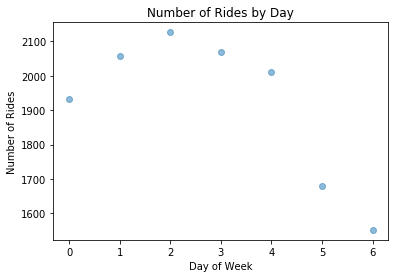

In [40]:
x=cb.startday.value_counts().index
y=cb.startday.value_counts()/(343) #divide by number of weeks to get mean rides per day
plt.scatter(x, y, alpha=0.5)
plt.xlabel('Day of Week')
plt.ylabel('Number of Rides')
plt.title('Number of Rides by Day')
plt.show()

Inspect number of rides per hour:

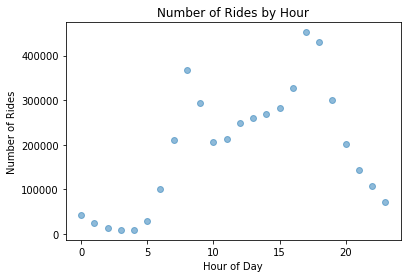

In [41]:
x=cb.starthour.value_counts().index
y=cb.starthour.value_counts()
plt.scatter(x, y, alpha=0.5)
plt.xlabel('Hour of Day')
plt.ylabel('Number of Rides')
plt.title('Number of Rides by Hour')
plt.show()

Inspect number of rides per month:

In [42]:
index=[1,7,8,9,10,11,12]
#y[index] = y[index]*(6/7) #to fix over sampling from Jan 2020 and July-December 2013
y = y.round().astype('int32')

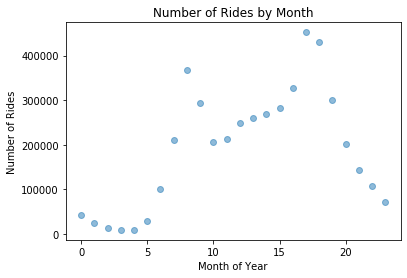

In [43]:
#ad-hocly adjusted for the oversampling of Jan, July-December months 
plt.scatter(x, y, alpha=0.5)
plt.xlabel('Month of Year')
plt.ylabel('Number of Rides')
plt.title('Number of Rides by Month')
plt.show()

Inspect `vicentydistance` by month:

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning:

To output multiple subplots, the figure containing the passed axes is being cleared



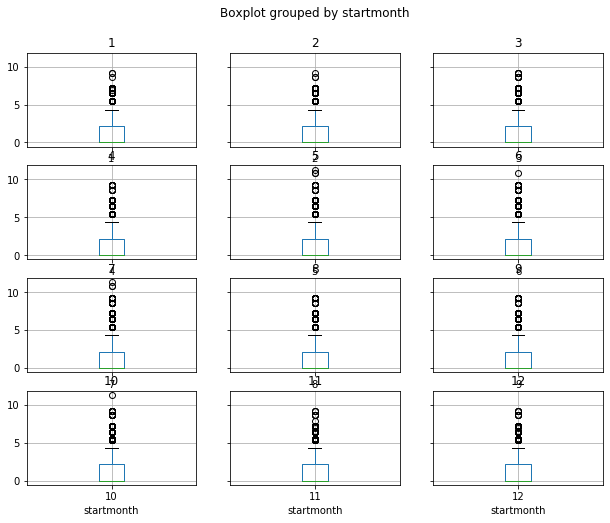

In [44]:
#adjusted for ease of interpretation
x=cb['vicentydistance'].sort_values(ascending=False).index
y=cb['vicentydistance'].sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(10,8))
plt.suptitle('')
cb.groupby('startmonth').boxplot(column=['vicentydistance'], by='startmonth', ax=ax)
plt.show()